### DCT3SNN - DCT-2 Encoded Dataset

The dataset is encoded using the padded generator matrix. the imaginary and real values are parellel processed until concatenation. The parallel execution mimics the DCT-III SNN. One additional layer is included to account for the scaling diagonal matrix $\hat{D}_n$ in the classical algorithm.

In [1]:
# (r + 1) | (q - 1)
# (r + 1) | n
# q is a prime number
# n = 2^t
# r < n

In [2]:
%reset -f
import gc
gc.collect()

0

In [3]:
import numpy as np

np.random.seed(42)

n = 16
q = 5
num_samples = 1000

def next_power_of_two(x):
    return 1 if x == 0 else 2**(x - 1).bit_length()

n_padded = next_power_of_two(n)

dataset = np.random.randint(0, q, size=(num_samples, n))

if n_padded > n:
    pad_width = n_padded - n
    dataset = np.pad(dataset, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)

print("Original n:", n)
print("Padded n:", n_padded)
print("Generated dataset shape:", dataset.shape)

Original n: 16
Padded n: 16
Generated dataset shape: (1000, 16)


In [4]:
print(dataset)
print(dataset.shape)
print(dataset[0].shape)

[[3 4 2 ... 1 3 1]
 [3 4 0 ... 3 2 3]
 [3 0 2 ... 0 1 4]
 ...
 [4 4 4 ... 0 2 2]
 [4 2 4 ... 4 0 0]
 [2 2 2 ... 0 4 2]]
(1000, 16)
(16,)


$$
\tilde{M}_{kj} = \left[ \left( \frac{w_0}{z_0} \right)^j \zeta^{kj} \right]_{k,j=0}^{n-1}
$$

In [5]:
def padded_generator_matrix(n, w0, z0):
    zeta = np.exp(-2j * np.pi / n)
    M_tilde = np.array([[(w0 / z0) ** j * zeta**(k * j) for j in range(n)] for k in range(n)], dtype=complex)
    return M_tilde

In [6]:
# (x, y, z, w) --> (1, 2, 3, 4)
w0 = 4
z0 = 3

M_tilde = padded_generator_matrix(n_padded, w0, z0)
print(M_tilde.shape)

(16, 16)


In [7]:
encoded_dataset = np.array([np.dot(M_tilde, x) for x in dataset])
encoded_dataset[np.abs(encoded_dataset) < 1e-10] = 0
encoded_dataset = np.round(encoded_dataset, decimals=10)
print(encoded_dataset)

[[ 649.89449698  +0.j           69.97998169+371.13335899j
   -83.92481787+137.40000024j ...  -88.37954911-103.22398682j
   -83.92481787-137.40000024j   69.97998169-371.13335899j]
 [ 695.87003951  +0.j          268.59479107+394.57072111j
   -36.50274968+309.16102475j ...  -47.36788425-179.88976988j
   -36.50274968-309.16102475j  268.59479107-394.57072111j]
 [ 540.63797786  +0.j          235.29809241+209.31041098j
   176.66145652+204.71795948j ...  108.87153914-320.22828928j
   176.66145652-204.71795948j  235.29809241-209.31041098j]
 ...
 [ 460.45123158  +0.j          162.64910275+168.11969395j
    54.45039471+219.81284778j ...  -26.91067254-124.72256855j
    54.45039471-219.81284778j  162.64910275-168.11969395j]
 [ 558.17613119  +0.j          -92.41727316+362.85897707j
  -228.64175513 +13.85662093j ...  -76.51498185+176.39278765j
  -228.64175513 -13.85662093j  -92.41727316-362.85897707j]
 [ 671.99178181  +0.j          161.97417378+352.04621278j
    43.09272997+244.01831359j ...  -56.208

In [8]:
encoded_dataset.shape

(1000, 16)

In [9]:
print(dataset[0])
print(encoded_dataset[0])

[3 4 2 4 4 1 2 2 2 4 3 2 4 1 3 1]
[ 649.89449698  +0.j           69.97998169+371.13335899j
  -83.92481787+137.40000024j  -88.37954911+103.22398682j
  -74.53901813 +41.73652084j  -97.48254893 +37.96448017j
 -147.95858217-108.15626408j   47.97234649-148.66691513j
  146.76987906  -0.j           47.97234649+148.66691513j
 -147.95858217+108.15626408j  -97.48254893 -37.96448017j
  -74.53901813 -41.73652084j  -88.37954911-103.22398682j
  -83.92481787-137.40000024j   69.97998169-371.13335899j]


In [10]:
X_real = np.real(encoded_dataset).astype(np.float32)
X_imag = np.imag(encoded_dataset).astype(np.float32)

print("\nX_train_real :", X_real.shape)
print(X_real[0])
print("\nX_train_imag :", X_imag.shape)
print(X_imag[0])


X_train_real : (1000, 16)
[ 649.8945     69.97998   -83.92482   -88.37955   -74.53902   -97.48255
 -147.95859    47.972347  146.76988    47.972347 -147.95859   -97.48255
  -74.53902   -88.37955   -83.92482    69.97998 ]

X_train_imag : (1000, 16)
[   0.        371.13336   137.4       103.22398    41.736523   37.96448
 -108.156265 -148.66692    -0.        148.66692   108.156265  -37.96448
  -41.736523 -103.22398  -137.4      -371.13336 ]


In [11]:
# normalize target data (integers 0-q to [0, 1])
y_normalized = dataset.astype(np.float32) / (q - 1)  # Scale to [0, 1]
print("y: ")
print(dataset.astype(np.float32)[0])
print("\ny_normalized: ")
print(y_normalized[0])

labels = y_normalized

y: 
[3. 4. 2. 4. 4. 1. 2. 2. 2. 4. 3. 2. 4. 1. 3. 1.]

y_normalized: 
[0.75 1.   0.5  1.   1.   0.25 0.5  0.5  0.5  1.   0.75 0.5  1.   0.25
 0.75 0.25]


In [12]:
from sklearn.model_selection import train_test_split

X_real_train, X_real_test, y_train, y_test = train_test_split(
    X_real, labels, test_size=0.2, random_state=42
)

X_imag_train, X_imag_test, _, _ = train_test_split(
    X_imag, labels, test_size=0.2, random_state=42
)

print("Training data shapes: X_real:", X_real_train.shape, "X_imag:", X_imag_train.shape, "y:", y_train.shape)
print("Testing data shapes: X_real:", X_real_test.shape, "X_imag:", X_imag_test.shape, "y:", y_test.shape)

Training data shapes: X_real: (800, 16) X_imag: (800, 16) y: (800, 16)
Testing data shapes: X_real: (200, 16) X_imag: (200, 16) y: (200, 16)


In [13]:
print(X_real_train.shape[1])
print(X_real_test.shape[1])
print(X_imag_train.shape[1])
print(X_imag_test.shape[1])
print(y_train.shape[1])
print(y_test.shape[1])

16
16
16
16
16
16


In [14]:
input_dim = X_real_train.shape[1]
output_dim = y_train.shape[1]
print(input_dim)
print(output_dim)

16
16


DCT-3 Structure Imposed Neural Network

In [15]:
import tensorflow as tf

In [16]:
class FirstLayer(tf.keras.layers.Layer):
  def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', use_bias=True, **kwargs):
    super(FirstLayer, self).__init__(**kwargs)
    self.units = units # features/neurons
    self.kernel_initializer = kernel_initializer
    self.bias_initializer = bias_initializer
    self.use_bias = use_bias

  def build(self, input_shape):
    # input_shape --> (batch_size, input_dim)
    n = self.units
    n1 = n // 2
    
    self.d_1 = self.add_weight(name ="kernel_d1",
                               shape=(n1,),
                               initializer=tf.keras.initializers.get(self.kernel_initializer),
                              #  regularizer=tf.keras.regularizers.l2(1e-4),
                               trainable=True)
    self.d_2 = self.add_weight(name ="kernel_d2",
                               shape=(n1,),
                               initializer=tf.keras.initializers.get(self.kernel_initializer),
                              #  regularizer=tf.keras.regularizers.l2(1e-4),
                               trainable=True)
    if self.use_bias:
      self.bias = self.add_weight(name ="bias",
                                  shape=(self.units,),
                                  initializer=tf.keras.initializers.get(self.bias_initializer),
                                  # regularizer=tf.keras.regularizers.l2(1e-4),
                                  trainable=True)

  def call(self, inputs):
    # print("Enters first layer")
    P_n = tf.concat([inputs[:, ::2], inputs[:, 1::2]], axis=1) # permutation [x0, x2, x4, ..., xn-2, x1, x3, x5, ..., xn-1]
    out1 = P_n[:, :int(P_n.shape[1]/2)] # even indices [x0 x2 x4 ...]
    out2 = P_n[:, int(P_n.shape[1]/2):] # odd indices [x1 x3 x5 ...]
    
    # expected output for rearrange out2 after bidiagonal matrix ---> out2_n = [sqrt(2).x1, x1+x3, x3+x5+ ..., xn-3+xn-1]   
    
    out3 = tf.add(
      tf.multiply(out2, self.d_1), # diagonal
      tf.multiply(tf.concat([tf.zeros_like(out2[:, :1]), out2[:, :-1]], axis=1), self.d_2) # super diagonal
    )
    
    out = tf.concat([out1, out3], axis=1) # [x0 x2 x4 ... sqrt(2).x1, x1+x3, x3+x5+ ..., xn-3+xn-1]

    if self.use_bias:
      out += self.bias

    return out

In [17]:
class SecondLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', use_bias=True, **kwargs):
        super(SecondLayer, self).__init__(**kwargs)
        self.units = units  # Number of neurons/features
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units
        n1 = n // 2
        num_blocks = n1 // 2  # Number of 2×2 blocks needed for c1 and c2 (for 16 we need 4 blocks)

        self.d_1 = self.add_weight(name="kernel_d1",
                                   shape=(n1 - 2,),
                                   initializer=tf.keras.initializers.get(self.kernel_initializer),
                                #    regularizer=tf.keras.regularizers.l2(1e-5),
                                   trainable=True)
        self.d_2 = self.add_weight(name="kernel_d2",
                                   shape=(n1 - 2,),
                                   initializer=tf.keras.initializers.get(self.kernel_initializer),
                                #    regularizer=tf.keras.regularizers.l2(1e-5),
                                   trainable=True)
        self.w = self.add_weight(name="kernel_w",
                                 shape=(n1 - 2,),
                                 initializer=tf.keras.initializers.get(self.kernel_initializer),
                                #  regularizer=tf.keras.regularizers.l2(1e-5),
                                 trainable=True)
    
        self.C_1 = self.add_weight(name="kernel_C_1",
                                   shape=(num_blocks, 2, 2),
                                   initializer=tf.keras.initializers.get(self.kernel_initializer),
                                #    regularizer=tf.keras.regularizers.l2(1e-5),
                                   trainable=True)
        self.C_2 = self.add_weight(name="kernel_C_2",
                                   shape=(num_blocks, 2, 2),
                                   initializer=tf.keras.initializers.get(self.kernel_initializer),
                                #    regularizer=tf.keras.regularizers.l2(1e-5),
                                   trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name="bias",
                                        shape=(self.units,),
                                        initializer=tf.keras.initializers.get(self.bias_initializer),
                                        # regularizer=tf.keras.regularizers.l2(1e-4),
                                        trainable=True)
    
    def call(self, inputs):
        # print("Enters second layer")
        
        def build_final_matrix(C, n1):
            """Constructs an n1 x n1 block-diagonal matrix from 2x2 blocks in C."""
            final_C = tf.eye(n1)  # initialize as an identity matrix
            num_blocks = n1 // 2

            for i in range(num_blocks):
                final_C = tf.tensor_scatter_nd_update(
                    final_C,
                    indices=[[2*i, 2*i], [2*i, 2*i+1], [2*i+1, 2*i], [2*i+1, 2*i+1]],
                    updates=tf.reshape(C[i], (-1,))
                )

            return final_C

        def recursiveDCTIII(inputVector, d_1, d_2, w, C, level):
            n = inputVector.shape[1]

            if n == 2:
                out = tf.matmul(inputVector, C[level])  # select correct 2×2 matrix
                return out
            else:
                P_n = tf.concat([inputVector[:, ::2], inputVector[:, 1::2]], axis=1)  # Permutation
                out1 = P_n[:, :n // 2]
                out2 = P_n[:, n // 2:]

                # Apply diagonal and superdiagonal scaling
                d1 = tf.multiply(out2, tf.reshape(d_1[:(n // 2)], (1, -1)))
                d2 = tf.concat([tf.zeros_like(out2[:, :1]), tf.multiply(out2[:, :-1], tf.reshape(d_2[:(n // 2) - 1], (1, -1)))], axis=1)
                out2_bn = tf.add(d1, d2)

                # Recursively apply DCT-III
                out1_n = recursiveDCTIII(out1, d_1[n // 2:], d_2[n // 2:], w[n // 2:], C, level + 1)
                out2_n = recursiveDCTIII(out2_bn, d_1[n // 2:], d_2[n // 2:], w[n // 2:], C, level + 1)

                out2_wn = tf.multiply(out2_n, tf.reshape(w[:n // 2], (1, -1)))

                out = (1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))) * tf.concat(
                    [(out1_n + out2_wn), tf.reverse((out1_n - out2_wn), axis=[1])], axis=1)

                return out

        input1 = inputs[:, :self.units // 2]
        input2 = inputs[:, self.units // 2:]

        z1 = recursiveDCTIII(input1, self.d_1, self.d_2, self.w, self.C_1, level=0)
        z2 = recursiveDCTIII(input2, self.d_1, self.d_2, self.w, self.C_2, level=0)
        
        final_C1 = build_final_matrix(self.C_1, self.units // 2)
        final_C2 = build_final_matrix(self.C_2, self.units // 2)

        z1 = tf.matmul(z1, final_C1)
        z2 = tf.matmul(z2, final_C2)

        out = tf.concat([z1, z2], axis=1)

        if self.use_bias:
            out += self.bias

        return out


In [18]:
class ThirdLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', use_bias=True, **kwargs):
        super(ThirdLayer, self).__init__(**kwargs)
        self.units = units # features/neurons
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units
        n1 = n // 2
        
        self.w = self.add_weight(name ="kernel_w",
                                      shape=(n1,),
                                      initializer=tf.keras.initializers.get(self.kernel_initializer),
                                    #   regularizer=tf.keras.regularizers.l2(1e-4),
                                      trainable=True)
        # self.h = self.add_weight(name ="kernel_h",
        #                               shape = (2,2),
        #                               initializer='glorot_normal',
        #                               trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name ="bias",
                                       shape=(self.units,),
                                       initializer=tf.keras.initializers.get(self.bias_initializer),
                                    #    regularizer=tf.keras.regularizers.l2(1e-4),
                                       trainable=True)

    def call(self, inputs):
        # print("Enters third layer")
        
        out1 = inputs[:, :int(inputs.shape[1] / 2)]
        out2 = inputs[:, int(inputs.shape[1] / 2):]

        # out1 - stays as is
        out3 = tf.multiply(out2, self.w)
        
        # TODO: make H trainable instead of hardcoded
        
        out = (1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))) * tf.concat([(out1 + out3), tf.reverse((out1 - out3), axis=[1])], axis=1)
        
        if self.use_bias:
            out += self.bias

        return out

In [19]:
class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', use_bias=True, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        self.units = units # features/neurons
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units
        
        self.m = self.add_weight(name ="kernel_m",
                                      shape=(n,),
                                      initializer=tf.keras.initializers.get(self.kernel_initializer),
                                    #   regularizer=tf.keras.regularizers.l2(1e-4),
                                      trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name ="bias",
                                       shape=(self.units,),
                                       initializer=tf.keras.initializers.get(self.bias_initializer),
                                    #    regularizer=tf.keras.regularizers.l2(1e-4),
                                       trainable=True)

    def call(self, inputs):
        # print("Enters custom layer")

        out = tf.multiply(inputs, self.m)
        
        if self.use_bias:
            out += self.bias

        return out

only difference between the gen matrix encoded and dct encoded is the linear mapping (m weight matrix)

In [20]:
class LinearLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='ones', bias_initializer='zeros', use_bias=True, **kwargs):
        super(LinearLayer, self).__init__(**kwargs)
        self.units = units
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units

        self.m = self.add_weight(name="kernel_m_1",
                                 shape=(n,),
                                 initializer=tf.keras.initializers.get(self.kernel_initializer),
                                 trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name="bias",
                                        shape=(self.units,),
                                        initializer=tf.keras.initializers.get(self.bias_initializer),
                                        trainable=True)

    def call(self, inputs):
        # print("linear layer input:", inputs.shape)

        inputs1 = inputs[:, :int(inputs.shape[1] / 2)]
        inputs2 = inputs[:, int(inputs.shape[1] / 2):]

        out = tf.math.sqrt(inputs1**2 + inputs2**2)
        out = tf.multiply(out, self.m)

        if self.use_bias:
            out += self.bias

        # print("linear layer output:", out.shape)
        return out

Compile Model

In [21]:
from tensorflow.keras.initializers import Initializer

class CustomScalingInitializer(Initializer):
    def __init__(self, n, w0, z0):
        self.n = n
        self.w0 = w0
        self.z0 = z0

    def __call__(self, shape, dtype=None):
        return tf.convert_to_tensor([(self.z0 / self.w0) ** k for k in range(self.n)], dtype=dtype)

    def get_config(self):
        return {"n": self.n, "w0": self.w0, "z0": self.z0}

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam

def cosine_loss(y_true, y_pred):
    y_true_norm = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_norm = tf.nn.l2_normalize(y_pred, axis=-1)
    return 1 - tf.reduce_mean(tf.reduce_sum(y_true_norm * y_pred_norm, axis=-1))

def mse_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse

def hybrid_loss(y_true, y_pred):
    mse_part = tf.reduce_mean(tf.square(y_true - y_pred))
    cos_part = cosine_loss(y_true, y_pred)
    return 0.5 * mse_part + 0.5 * cos_part


def structured_NN(input_dim, output_dim):
    real_input = Input(shape=(input_dim,), name="real_input")
    imag_input = Input(shape=(input_dim,), name="imag_input")
    
    # he_normal
    # glorot_normal
    # glorot_uniform
    
    real_x = FirstLayer(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="real_layer_1")(real_input)
    real_x = LeakyReLU(alpha=0.1)(real_x)
    # real_x = CustomLayer(units=input_dim, kernel_initializer='he_normal', bias_initializer='zeros', name="real_support_layer_1")(real_x)
    # real_x = LeakyReLU(alpha=0.1)(real_x)
    real_x = SecondLayer(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="real_layer_2")(real_x)
    real_x = LeakyReLU(alpha=0.1)(real_x)
    # real_x = CustomLayer(units=input_dim, kernel_initializer='he_normal', bias_initializer='zeros', name="real_support_layer_2")(real_x)
    # real_x = LeakyReLU(alpha=0.1)(real_x)
    real_x = ThirdLayer(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="real_layer_3")(real_x)
    real_x = LeakyReLU(alpha=0.1)(real_x)

    imag_x = FirstLayer(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="imag_layer_1")(imag_input)
    imag_x = LeakyReLU(alpha=0.1)(imag_x)
    # imag_x = CustomLayer(units=input_dim, kernel_initializer='he_normal', bias_initializer='zeros', name="imag_support_layer_1")(imag_x)
    # imag_x = LeakyReLU(alpha=0.1)(imag_x)
    imag_x = SecondLayer(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="imag_layer_2")(imag_x)
    imag_x = LeakyReLU(alpha=0.1)(imag_x)
    # imag_x = CustomLayer(units=input_dim, kernel_initializer='he_normal', bias_initializer='zeros', name="imag_support_layer_2")(imag_x)
    # imag_x = LeakyReLU(alpha=0.1)(imag_x)
    imag_x = ThirdLayer(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="imag_layer_3")(imag_x)
    imag_x = LeakyReLU(alpha=0.1)(imag_x)

    merged = Concatenate(name="merge_real_imag")([real_x, imag_x])
    
    # output = CustomLayer(units=input_dim * 2, kernel_initializer=CustomScalingInitializer(n=input_dim * 2, w0=w0, z0=z0), 
    #                      bias_initializer='zeros', name="diagonal_scaling_layer")(merged)
    output = CustomLayer(units=input_dim * 2, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="diagonal_scaling_layer")(merged)
    output = LeakyReLU(alpha=0.1)(output)
    output = LinearLayer(units=output_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="output_layer")(output)
    output = Activation('sigmoid')(output) #sigmoid #tanh #linear

    model = Model(inputs=[real_input, imag_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss, metrics=['mse', 'mae'])

    return model

input_dim = X_real_train.shape[1]
output_dim = y_train.shape[1]
model = structured_NN(input_dim, output_dim)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 real_input (InputLayer)     [(None, 16)]                 0         []                            
                                                                                                  
 imag_input (InputLayer)     [(None, 16)]                 0         []                            
                                                                                                  
 real_layer_1 (FirstLayer)   (None, 16)                   32        ['real_input[0][0]']          
                                                                                                  
 imag_layer_1 (FirstLayer)   (None, 16)                   32        ['imag_input[0][0]']          
                                                                                             

In [23]:
for layer in model.layers:
    print(layer.name, layer.output_shape)

real_input [(None, 16)]
imag_input [(None, 16)]
real_layer_1 (None, 16)
imag_layer_1 (None, 16)
leaky_re_lu (None, 16)
leaky_re_lu_3 (None, 16)
real_layer_2 (None, 16)
imag_layer_2 (None, 16)
leaky_re_lu_1 (None, 16)
leaky_re_lu_4 (None, 16)
real_layer_3 (None, 16)
imag_layer_3 (None, 16)
leaky_re_lu_2 (None, 16)
leaky_re_lu_5 (None, 16)
merge_real_imag (None, 32)
diagonal_scaling_layer (None, 32)
leaky_re_lu_6 (None, 32)
output_layer (None, 16)
activation (None, 16)


Training the NN

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

adjust_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [25]:
history = model.fit(
    [X_real_train, X_imag_train],
    y_train,
    epochs=500,
    batch_size=16,
    validation_data=([X_real_test, X_imag_test], y_test),
    callbacks=[adjust_lr, early_stopping]
)

Epoch 1/500


50/50 [==============================] - 13s 42ms/step - loss: 0.1707 - mse: 0.1395 - mae: 0.3203 - val_loss: 0.1628 - val_mse: 0.1310 - val_mae: 0.3125 - lr: 0.0010
Epoch 2/500
50/50 [==============================] - 0s 5ms/step - loss: 0.1556 - mse: 0.1274 - mae: 0.3089 - val_loss: 0.1558 - val_mse: 0.1257 - val_mae: 0.3058 - lr: 0.0010
Epoch 3/500
50/50 [==============================] - 0s 4ms/step - loss: 0.1520 - mse: 0.1247 - mae: 0.3049 - val_loss: 0.1535 - val_mse: 0.1239 - val_mae: 0.3030 - lr: 0.0010
Epoch 4/500
50/50 [==============================] - 0s 5ms/step - loss: 0.1505 - mse: 0.1235 - mae: 0.3030 - val_loss: 0.1520 - val_mse: 0.1228 - val_mae: 0.3012 - lr: 0.0010
Epoch 5/500
50/50 [==============================] - 0s 5ms/step - loss: 0.1493 - mse: 0.1227 - mae: 0.3014 - val_loss: 0.1508 - val_mse: 0.1219 - val_mae: 0.2997 - lr: 0.0010
Epoch 6/500
50/50 [==============================] - 0s 7ms/step - loss: 0.1484 - mse: 0.1219 - mae: 0.3001 - val_lo

Evaluate

In [26]:
test_loss, test_mse, test_mae = model.evaluate([X_real_test, X_imag_test], y_test)
print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")

7/7 [==============================] - 0s 4ms/step - loss: 0.1128 - mse: 0.0921 - mae: 0.2433
Test MSE: 0.0921, Test MAE: 0.2433


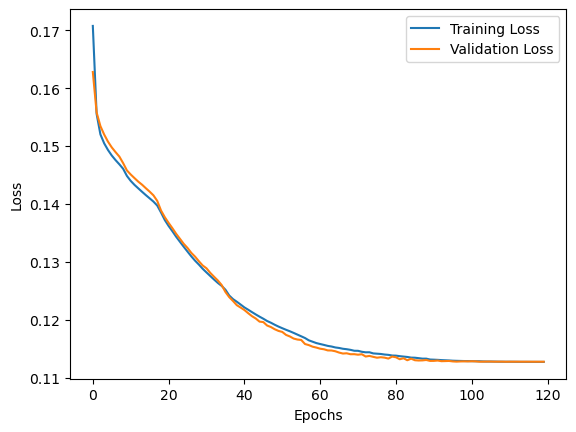

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
y_pred_test = model.predict([X_real_test, X_imag_test])
y_pred_test_rescaled = y_pred_test * (q - 1)
y_test_rescaled = y_test * (q - 1)

print("Comparison of predictions and ground truth:")
for i in range(3):
    print(f"Sample {i+1}:")
    print(f"predicted as is: ", y_pred_test[i])
    print(f"  Predicted:    {np.round(y_pred_test_rescaled[i])}")
    print(f"  Ground Truth: {np.round(y_test_rescaled[i])}")
    print("-" * 40)

7/7 [==============================] - 2s 3ms/step
Comparison of predictions and ground truth:
Sample 1:
predicted as is:  [0.48633242 0.4861646  0.48073894 0.5032941  0.4964755  0.4988162
 0.5002389  0.4910947  0.4849074  0.48880762 0.53606254 0.34193242
 0.25931448 0.3225183  0.9208442  0.43935198]
  Predicted:    [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 4. 2.]
  Ground Truth: [1. 0. 1. 1. 1. 1. 3. 0. 1. 3. 1. 2. 1. 1. 4. 2.]
----------------------------------------
Sample 2:
predicted as is:  [0.49705675 0.48679802 0.49531263 0.50319725 0.49753606 0.49883005
 0.49668062 0.48524767 0.49537262 0.51703924 0.50907946 0.7093346
 0.65734375 0.07373916 0.23822236 0.10370464]
  Predicted:    [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 0. 1. 0.]
  Ground Truth: [4. 0. 2. 0. 2. 0. 3. 2. 1. 2. 2. 2. 3. 0. 1. 0.]
----------------------------------------
Sample 3:
predicted as is:  [0.49717757 0.48586762 0.49903563 0.50495344 0.49695113 0.4988446
 0.49399972 0.50953734 0.46826348 0.5266119  0.4037

In [29]:
num_unseen_samples = 5
unseen_data = np.random.randint(0, q, size=(num_unseen_samples, n))

padded_unseen_data = np.hstack((unseen_data, np.zeros((num_unseen_samples, n_padded - n))))

unseen_data_normalized = unseen_data.astype(np.float32) / (q - 1)

# print("Unseen Input Data (Before Encoding):")
# print(unseen_data)

unseen_encoded = np.array([np.dot(M_tilde, x) for x in padded_unseen_data])
unseen_encoded[np.abs(unseen_encoded) < 1e-10] = 0
unseen_encoded = np.round(unseen_encoded, decimals=10)

X_real_unseen = np.real(unseen_encoded).astype(np.float32)
X_imag_unseen = np.imag(unseen_encoded).astype(np.float32)

print("\nEncoded Unseen Data (Real and Imaginary Parts):")
print("Real Part Shape:", X_real_unseen.shape)
print("Imaginary Part Shape:", X_imag_unseen.shape)

y_pred_unseen = model.predict([X_real_unseen, X_imag_unseen])

y_pred_unseen_rescaled = y_pred_unseen * (q - 1)

y_pred_unseen_final = np.mod(np.round(y_pred_unseen_rescaled), q)

print("\nComparison of Unseen Data and Predictions:")
print("=" * 60)
for i in range(num_unseen_samples):
    print(f"Sample {i+1}:")
    print(f"  Ground Truth: {padded_unseen_data[i].astype(int)}")
    print(f"  Prediction  : {y_pred_unseen_final[i].astype(int)}")
    print("-" * 60)


Encoded Unseen Data (Real and Imaginary Parts):
Real Part Shape: (5, 16)
Imaginary Part Shape: (5, 16)
1/1 [==============================] - 0s 42ms/step

Comparison of Unseen Data and Predictions:
Sample 1:
  Ground Truth: [2 3 2 1 0 0 0 4 4 1 2 4 2 2 4 4]
  Prediction  : [2 2 2 2 2 2 2 2 2 2 2 3 2 1 4 4]
------------------------------------------------------------
Sample 2:
  Ground Truth: [1 3 0 4 4 2 3 4 3 0 2 1 0 3 3 0]
  Prediction  : [2 2 2 2 2 2 2 2 2 2 2 2 1 3 2 0]
------------------------------------------------------------
Sample 3:
  Ground Truth: [3 1 1 3 3 1 3 4 2 4 3 3 2 3 2 1]
  Prediction  : [2 2 2 2 2 2 2 2 2 2 2 3 2 3 1 1]
------------------------------------------------------------
Sample 4:
  Ground Truth: [2 2 4 3 1 0 2 0 3 2 0 4 0 4 1 3]
  Prediction  : [2 2 2 2 2 2 2 2 2 2 2 3 1 3 2 3]
------------------------------------------------------------
Sample 5:
  Ground Truth: [0 2 3 0 2 2 2 2 0 1 4 4 4 1 2 2]
  Prediction  : [2 2 2 2 2 2 2 2 2 2 2 3 3 1 1 2]
------

Check Gradient Flow

In [30]:
for layer in model.layers:
    if layer.trainable_variables:
        grads = tf.reduce_mean(tf.abs(layer.trainable_variables[0]))
        print(layer.name, "Gradient Mean:", grads.numpy())
    else:
        print(layer.name, "has no trainable variables.")

real_input has no trainable variables.
imag_input has no trainable variables.
real_layer_1 Gradient Mean: 0.6040417
imag_layer_1 Gradient Mean: 0.30142528
leaky_re_lu has no trainable variables.
leaky_re_lu_3 has no trainable variables.
real_layer_2 Gradient Mean: 0.6628104
imag_layer_2 Gradient Mean: 0.29396912
leaky_re_lu_1 has no trainable variables.
leaky_re_lu_4 has no trainable variables.
real_layer_3 Gradient Mean: 0.62275213
imag_layer_3 Gradient Mean: 0.45728993
leaky_re_lu_2 has no trainable variables.
leaky_re_lu_5 has no trainable variables.
merge_real_imag has no trainable variables.
diagonal_scaling_layer Gradient Mean: 0.2913307
leaky_re_lu_6 has no trainable variables.
output_layer Gradient Mean: 0.5089798
activation has no trainable variables.


In [31]:
batch_size = 4 
X_real_dummy = np.random.rand(batch_size, X_real_train.shape[1]).astype(np.float32)
X_imag_dummy = np.random.rand(batch_size, X_imag_train.shape[1]).astype(np.float32)
y_dummy = np.random.rand(batch_size, y_train.shape[1]).astype(np.float32)

def check_gradients(model, X_real_dummy, X_imag_dummy, y_dummy):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        predictions = model([X_real_dummy, X_imag_dummy], training=True)
        loss = tf.keras.losses.mean_squared_error(y_dummy, predictions)

    grads = tape.gradient(loss, model.trainable_variables)

    for i, (grad, var) in enumerate(zip(grads, model.trainable_variables)):
        if grad is None:
            print(f"🚨 Gradient is None for {var.name} at index {i}")
        else:
            print(f"✅ Gradient OK for {var.name}, mean: {tf.reduce_mean(grad).numpy()}")

check_gradients(model, X_real_dummy, X_imag_dummy, y_dummy)

✅ Gradient OK for real_layer_1/kernel_d1:0, mean: 0.0001550926681375131
✅ Gradient OK for real_layer_1/kernel_d2:0, mean: 6.899983418406919e-05
✅ Gradient OK for real_layer_1/bias:0, mean: 0.0004951264709234238
✅ Gradient OK for imag_layer_1/kernel_d1:0, mean: 0.00013981651864014566
✅ Gradient OK for imag_layer_1/kernel_d2:0, mean: 1.5891451766947284e-05
✅ Gradient OK for imag_layer_1/bias:0, mean: 0.00033514344249852
✅ Gradient OK for real_layer_2/kernel_d1:0, mean: 0.0009915679693222046
✅ Gradient OK for real_layer_2/kernel_d2:0, mean: 0.0006112392875365913
✅ Gradient OK for real_layer_2/kernel_w:0, mean: -0.0036891985218971968
✅ Gradient OK for real_layer_2/kernel_C_1:0, mean: -0.00041032821172848344
✅ Gradient OK for real_layer_2/kernel_C_2:0, mean: 0.00023541174596175551
✅ Gradient OK for real_layer_2/bias:0, mean: 0.0006862310110591352
✅ Gradient OK for imag_layer_2/kernel_d1:0, mean: -0.0012795616639778018
✅ Gradient OK for imag_layer_2/kernel_d2:0, mean: 0.0007310691871680319
✅